# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 

>**Tip**: Though it's not a mandate, students can attempt the classroom quizzes to ensure statistical numeric values are calculated correctly in many cases.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.


>**Tip**: Please save your work regularly.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv', parse_dates = [1])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df_len = df.shape[0]
df_len

294478

**c.** The number of unique users in the dataset.

In [4]:
unq_usr_count = df.user_id.nunique()
unq_usr_count

290584

**d.** The proportion of users converted.

In [5]:
cnv_usr_count = df.query('converted==1')['user_id'].nunique()
prp_cnv_usr = cnv_usr_count / unq_usr_count
prp_cnv_usr

0.12104245244060237

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
#df.groupby(['group','landing_page'])['user_id'].nunique().reset_index()
inacc_rows_count = df.query('(group =="treatment" & landing_page != "new_page") | (group == "control" & landing_page == "new_page")')['user_id'].count()
inacc_rows_count

3893

**f.** Do any of the rows have missing values?

In [7]:
num_row_mis_val = df.isnull().any(axis = 1).sum()
num_row_mis_val

0

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
# I used here query using an inverted condition for the one above I used to get the number of inaccurate rows
df2 = df.query('~((group =="treatment" & landing_page != "new_page") | (group == "control" & landing_page == "new_page"))')
df2.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2_unq_usr_count = df2.user_id.nunique()
df2_unq_usr_count

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(2893,axis=0,inplace=True);
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'].duplicated()];

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       290584 non-null  int64         
 1   timestamp     290584 non-null  datetime64[ns]
 2   group         290584 non-null  object        
 3   landing_page  290584 non-null  object        
 4   converted     290584 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 13.3+ MB


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

>**Tip**: The probability  you'll compute represents the overall "converted" success rate in the population and you may call it $p_{population}$.



In [15]:
p_pop = df2['converted'].mean()
p_pop 

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
p_ctrl = df2.query('group == "control"')['converted'].mean()
p_ctrl

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
p_trt = df2.query('group == "treatment"')['converted'].mean()
p_trt

0.11880806551510564

>**Tip**: The probabilities you've computed in the points (b). and (c). above can also be treated as conversion rate. 
Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. You will need that later.  

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_trt - p_ctrl
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [19]:
num_usr_new_page = df2.query('landing_page == "new_page"')['user_id'].count()
p_new_page = num_usr_new_page/df2_unq_usr_count
p_new_page

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

## >**Your answer goes here.**

 

<span style="color:blue">
From the cleaned data (df2), the users of the "new page" don't convert (pay for the company products) in high rates compared to the "old page" users. Still we need to check the statistical significance of this conclusion, putting into consideration that we still look to a sample of the population and change aversion (or other reasons) may be the reasons we are not seeing the new page potential.
</span>

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**Put your answer here.**
<span style="color:blue">
$$ H_0: p_{new}-p_{old} <= 0 $$
$$ H_1: p_{new}-p_{old} > 0 $$
</span>

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [20]:
df_control = df2.query('group == "control"')
df_treatment = df2.query('group == "treatment"')

In [21]:
#based on our assumption of p_new = p_old = p_population
p_new = df2.converted.mean() 
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
p_old =p_new
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [23]:
n_new=df_treatment.shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old=df_control.shape[0]
n_old

145274

In [25]:
p_new-p_old

0.0

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [26]:
# Simulate a Sample for the treatment Group
new_page_converted =(np.random.choice([0,1],size=n_new,p=[1-p_new,p_new]))

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [27]:
# Simulate a Sample for the control Group
old_page_converted=(np.random.choice([0,1],size=n_old,p=[1-p_old,p_old]))

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [28]:
new_page_converted.mean()-old_page_converted.mean()

-0.00040134222356717764


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [29]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    new_page_converted =(np.random.choice([0,1],size=n_new,p=[1-p_new,p_new]))
    old_page_converted=(np.random.choice([0,1],size=n_old,p=[1-p_old,p_old]))
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())
p_diffs = np.array(p_diffs)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

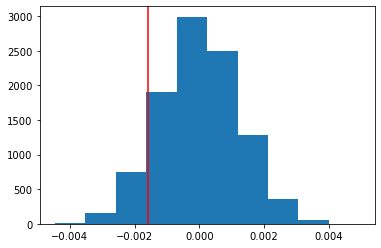

In [30]:
plt.hist(p_diffs);
plt.axvline(obs_diff,color='red')

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [31]:
p_val = (p_diffs > obs_diff).mean()
p_val

0.9004

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**Put your answer here.**

<span style="color:blue">
p-value = 0.9043 which is far above our type I assumption of 0.05
Then we failed to reject the null hypothesis.
The available data is telling that old page is equal or better than new page
</span>



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [32]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df_control.query('converted == 1')['user_id'].count()

# number of conversions with the new_page
convert_new = df_treatment.query('converted == 1')['user_id'].count()

# number of individuals who were shown the old_page
n_old = df_control.shape[0]

# number of individuals who received new_page
n_new = df_treatment.shape[0]
convert_old, n_old, convert_new, n_new


(17489, 145274, 17264, 145310)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [33]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
count = np.array([convert_new,convert_old])
nobs = np.array([n_new, n_old])
#stat, pval = proportions_ztest(count, nobs)
#print('{0:0.3f}'.format(pval))
z_score, p_value = sm.stats.proportions_ztest(count,nobs,alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Tip**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

>**Put your answer here.**

<span style="color:blue">
p_value is the same as concluded in the bootstrapping excercise.
 z(5%) = -1.64 and z_score = -1.311 larger than z_alpha we can conclude the same like the above scenario of failing to reject null hypothesis.
</span>

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Put your answer here.**

Logistic Regression is the selected for this as it can predict data on format of (0,1) based on the input parameters

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [34]:
df2['intercept']=1
df_reg = df2.join(pd.get_dummies(df2['group'],drop_first=True))
df_reg.rename(columns={'treatment':'ab_page'}, inplace=True)

<ipython-input-34-897ba6f2c5f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept']=1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [35]:
lm = sm.Logit(df_reg['converted'],df_reg[['intercept','ab_page']])
model = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 20 Feb 2022   Pseudo R-squ.:               8.077e-06
Time:                        22:28:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [37]:
np.exp(model.params[1])

0.9851226640350378

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>**Put your answer here.**

<span style="color:blue">
ab_page represents the independent variable of being a member of treatment group. with p_value = 0.19 > type I error of 0.05 we can conclude that belonging to this group can't mean the associated decrease conversion rate of (0.985) calculated in d.
Still we are in the same page of can't say that the new page can enhance the conversion rate. Based on this excercise it worsen the conversion.

The hypotheses associated with your regression model is stating that conversion rate is not affected by treatment group membership and we failed to reject this null hypothesis.
</span>

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Put your answer here.**

<span style="color:blue">
So far the experiment concluded that the new page will not enhance the conversion ratio. Then adding other factors like country or time may lead to different results. The disadvantages are the linear independence of the variables. and the interpretation of the accuracy of the built model as many factors interact.
</span>

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [38]:
# Read the countries.csv
countries_df = pd.read_csv('countries.csv')


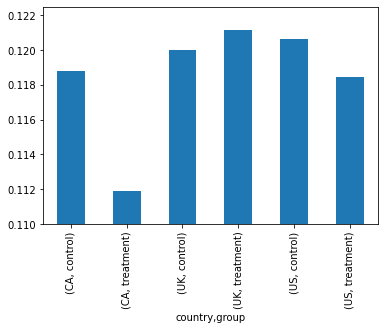

In [39]:
# Join with the df2 dataframe
df_merged = countries_df.set_index('user_id').join(df_reg.set_index('user_id'), how='inner')
# Just illustrate how conversion is happening per country
(df_merged.groupby(['country','group'])['converted'].mean()).plot(kind='bar',ylim=(0.11,0.1225));

In [40]:
# Create the necessary dummy variables
df_reg2 = df_merged.join(pd.get_dummies(df_merged['country'],drop_first=True))
df_reg2.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


<span style="color:blue">
Before dive into regression model, it seems that UK+{new page} is having the highest conversion ratio more than any other country and even more than UK+{old page}
Let us check the statistical significance of this observation.
</span>

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [41]:
# Fit your model, and summarize the results
df_reg2['US_ab_page'] = df_reg2['US'] * df_reg2['ab_page']
df_reg2['UK_ab_page'] = df_reg2['UK'] * df_reg2['ab_page']
lm_ctr = sm.Logit(df_reg2['converted'],df_reg2[['UK_ab_page','US_ab_page','intercept']])
model_ctr = lm_ctr.fit()
model_ctr.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 20 Feb 2022   Pseudo R-squ.:               1.082e-05
Time:                        22:28:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3164
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
UK_ab_page     0.0112      0.018      0.626      0.532      -0.024       0.046
US_ab_page    -0.0144      0.012     -1.155      0.248      -0.039       0.010
intercept     -1.9926      0.008   -252.910      0.000      -2.008      -1.977
==============================================================================
"""

In [42]:
np.exp(model_ctr.params.loc['UK_ab_page'])

1.011292053522841

<span style="color:blue">
Adding the countries to the model doesn't enhance the prediction quality as the p-value for the added variables is higher compared to the Type I error. Also in g, we noticed UK with new page is having higher conversion ratio but the associated p-value (=0.532) is very high which signify the shortfall of this conclusion. 
</span>

In [43]:
df_reg2['DayofYear']=(pd.DatetimeIndex(df_reg2['timestamp']).dayofyear)
df_reg2.head(5)

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,US_ab_page,UK_ab_page,DayofYear
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0,14
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,1,0,23
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,0,1,16
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0,22
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,0,1,16


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Sun, 20 Feb 2022   Pseudo R-squ.:               3.321e-05
Time:                        22:28:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1324
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0407      0.027      1.513      0.130      -0.012       0.093
ab_page       -0.0149      0.011     -1.304      0.192      -0.037       0.007
DayofYear      0.0013      0.001      1.457      0.145      -0.000       0.003
intercept     -2.0471      0.029    -70.340      0.000      -2.104      -1.990
==============================================================================
"""

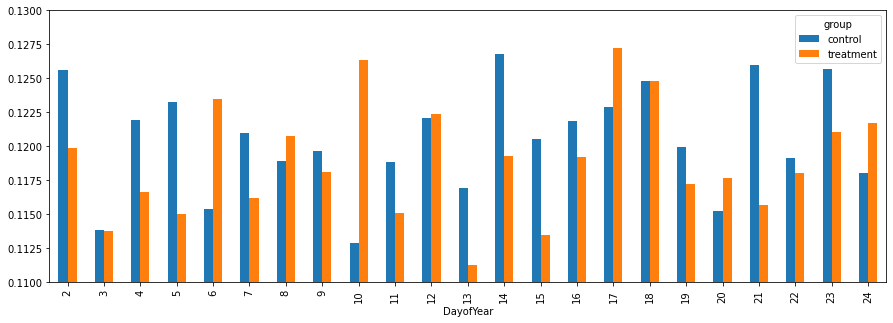

In [44]:
# Just illustrate how conversion is happening per day
# We can see some seasonality in conversion using new page
pivot = df_reg2.pivot_table('converted','DayofYear','group',aggfunc='mean')
pivot.plot(kind='bar',figsize=(15,5),ylim=(0.11,0.13));
lm_ctr_tim = sm.Logit(df_reg2['converted'],df_reg2[['UK','US','ab_page','DayofYear','intercept']])
model_ctr_tim = lm_ctr_tim.fit()
model_ctr_tim.summary()

In [45]:
np.exp(model_ctr_tim.params.loc['DayofYear'])

1.0013101686360113

>**Put your conclusion answer here.**

<span style="color:blue">
After the addition of the DayofYear variable it revealed another variable which its associated p_val is also high. So it is critical to consider its impact on the conversion rate. But may be it can highlight that it is safer to run the experiment for longer time as the addition of this variable reveal that the more we advance in time the conversion ratio linearly increases.
</span>

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your notebook to make sure that it satisfies all the specifications mentioned in the rubric. You should also probably remove all of the "Hints" and "Tips" like this one so that the presentation is as polished as possible.


<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [46]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

4294967295